# CIS 5200: Machine Learning
## Homework 0

# PyTorch

Programming assignments will be primarily done in PyTorch. If you've used NumPy before, then you'll find that PyTorch has many of the same functionalities plus more.

The base object in PyTorch is the Tensor. See this tutorial for a brief primer on the syntax: https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html

In [ ]:
import torch

A = torch.randn(5,6)
print(A)

tensor([[-0.5630, -2.4358, -2.2855,  0.4215, -1.5918,  0.9845],
        [-0.7088,  0.7605,  1.3753,  0.1590, -0.6767, -0.7614],
        [-0.1119,  0.8294, -0.9644,  0.3012, -0.8575,  0.6480],
        [-0.4721,  0.2630,  0.3377, -0.6050, -0.2461, -1.9892],
        [ 1.5788, -0.0502,  1.1109, -0.3504,  0.9900,  0.5795]])



Nearly all low-level functions are already implemented in PyTorch. *Check the documentation before implementing anything yourself*: https://pytorch.org/docs/stable/index.html

Many functions are built-in to the `torch.Tensor` object. For example, instead of calling `torch.sum(X)`, you can call `X.sum()` directly. Some of these functions such as `matmul`, `mm`, or `dot` will be useful for implementing matrix operations. A full list of tensor operations can be found here: https://pytorch.org/docs/stable/tensors.html

In [ ]:
A = torch.randn(5,6)
B = torch.randn(6,2)
print(A.mm(B))

tensor([[ 5.1385, -3.9084],
        [ 2.2979,  2.1807],
        [-1.8222,  2.6902],
        [ 1.0234,  2.8884],
        [ 0.8198,  5.4873]])


PyTorch has a fairly extensive distributions library, which allows you to generate samples, compute probabilities, and other statistical quantities. In this example we can construct a Bernoulli random variable with parameter $p=0.8$ and calculate the log probability of the following observations `[1,0,0,1,1]`.

In [ ]:
from torch.distributions.bernoulli import Bernoulli

X = Bernoulli(0.8)
print(X.log_prob(torch.Tensor([1,0,0,1,1])))

tensor([-0.2231, -1.6094, -1.6094, -0.2231, -0.2231])


# Matrix operations
Let $X\in \mathbb R^{m\times n}$ be a data matrix of $m$ samples with $n$ features. Implement the batched sample gradient, $\nabla_X f(X)$, for each of the calculus problems from the written homework. The batched sample gradient is the $m\times n$ matrix where the $i$th row is the gradient of $f$ with respect to the $i$th sample.

Do so using matrix operations without any for loops. We cannot explicitly check for loops, so in order to pass, your each of your functions needs to pass the Penngrader tests in less than 0.01 seconds. For reference, a solution using matrix operations can pass each test in less than 0.001 seconds, while solutions using for loops tend to take more than 0.1 seconds.

As an example, the first one has been done for you.

Some variables other than $X$ can also be batched, such as sample labels $Y \in \mathbb R^{m}$. For such functions, the $i$th sample gradient of these examples is taken with respect to the sample $x_i$ using the sample label $y_i$: $\nabla_{x_i} f(x_i,y_i)$.


1. $f(x_i;w) = w^\top x_i$
2. $f(x_i) = x_i^\top x_i$
3. $f(x_i,y_i;w) = (y_i-w^\top x_i)^2$
4. $f(x_i,y_i;w) = \log(1 + \exp(-y_iw^\top x_i))$
5. $f(x_i;A) = x_i^\top Ax_i$

In [ ]:
import torch

def grad1(X, w):
    # X := Tensor of size (m,n)
    # w := Tensor of size (n,)
    # Return := Tensor of size (m,n)
    m = X.size(0)
    return w.repeat(m,1)

def grad2(X):
    # X := Tensor of size (m,n)
    # Return := Tensor of size (m,n)
    # pass
    answer = 2 * X
    return answer

def grad3(X, y, w):
    # X := Tensor of size (m,n)
    # y := Tensor of size (m,)
    # w := Tensor of size (n,)
    # Return := Tensor of size (m,n)
    # should be −2(y−Xw)w^T
    cal = y - X @ w # calculate the yi−w⊤xi
    cal_final = cal.unsqueeze(1) # (m, -> m,1)
    w_t = w.unsqueeze(0)  # (n, -> 1,n)
    answer = -2.0 * cal_final * w_t
    return answer

def grad4(X, y, w):
    # X := Tensor of size (m,n)
    # y := Tensor of size (m,)
    # w := Tensor of size (n,)
    # Return := Tensor of size (m,n)
    # Hint: Check out torch.autograd.grad
    # pass
    # should be: −y (exp -y(Xw) / (1 + exp -y(Xw))) w
    z = -y * (X @ w)  # (m,)
    exp_one = torch.exp(z)  # (m,)
    coefficients = -y * exp_one/(1+exp_one)
    coeff_fin = coefficients.unsqueeze(1)  # (m,1)
    w_new = w.unsqueeze(0)  # (1,n)
    answer = coeff_fin * w_new  # (m,n)
    return answer

def grad5(X, A):
    # X := Tensor of size (m,n)
    # A := Tensor of size (n, n)
    # Return := Tensor of size (m,n)
    # pass
    # X(A+A^T)
    block = A + A.T
    answer = X @ block
    return answer


Do not edit the cell below. Run to check that your answers pass!

In [ ]:
# Run these to test your answers to grad1 to grad5
import torch, time, math
torch.set_default_dtype(torch.float64)
g = torch.Generator().manual_seed(5200)

def _randn(*shape):
    return torch.randn(*shape, generator=g)

def _bool(ok):
    return "PASS" if ok else "FAIL"

def _check_close(a, b, rtol=1e-6, atol=1e-8):
    return torch.allclose(a, b, rtol=rtol, atol=atol)

def _autograd_grad_X(f, X):
    """Return d/dX sum_i f_i(X[i])."""
    X = X.clone().detach().requires_grad_(True)
    y = f(X)
    s = y.sum()
    (GX,) = torch.autograd.grad(s, (X,))
    return GX

results = []

# a few sizes
cases = [(7, 5), (32, 16), (256, 64)]
for (m, n) in cases:
    X = _randn(m, n)
    w = _randn(n)
    y = torch.sign(_randn(m))
    A = _randn(n, n)

    # ----- grad1: f_i = w^T x_i
    t0 = time.perf_counter()
    G1 = grad1(X, w) # m*n
    t1 = time.perf_counter()
    ok_shape = (G1.shape == (m, n))
    ok_val = _check_close(G1, w.expand(m, -1))
    results.append(("grad1", (m,n), _bool(ok_shape and ok_val), f"{(t1-t0)*1e3:.3f} ms"))

    # cross-check with autograd
    def f1(X_):
        return (X_ @ w).reshape(-1)
    GA1 = _autograd_grad_X(f1, X)
    results.append(("grad1/autograd", (m,n), _bool(_check_close(G1, GA1)), ""))

    # ----- grad2: f_i = x_i^T x_i
    t0 = time.perf_counter()
    G2 = grad2(X)
    t1 = time.perf_counter()
    ok_shape = (G2.shape == (m, n))
    ok_val = _check_close(G2, 2*X)
    results.append(("grad2", (m,n), _bool(ok_shape and ok_val), f"{(t1-t0)*1e3:.3f} ms"))

    def f2(X_):
        return (X_ * X_).sum(dim=1)
    GA2 = _autograd_grad_X(f2, X)
    results.append(("grad2/autograd", (m,n), _bool(_check_close(G2, GA2)), ""))

    # ----- grad3: f_i = (y_i - w^T x_i)^2
    t0 = time.perf_counter()
    G3 = grad3(X, y, w)
    t1 = time.perf_counter()
    resid = (y - X @ w).unsqueeze(1)
    G3_ref = -2.0 * resid * w.unsqueeze(0)
    ok_shape = (G3.shape == (m, n))
    ok_val = _check_close(G3, G3_ref, rtol=1e-6, atol=1e-8)
    results.append(("grad3", (m,n), _bool(ok_shape and ok_val), f"{(t1-t0)*1e3:.3f} ms"))

    def f3(X_):
        return (y - (X_ @ w))**2
    GA3 = _autograd_grad_X(f3, X)
    results.append(("grad3/autograd", (m,n), _bool(_check_close(G3, GA3)), ""))

    # ----- grad4: f_i = log(1 + exp(-y_i w^T x_i))
    t0 = time.perf_counter()
    G4 = grad4(X, y, w)
    t1 = time.perf_counter()
    s = (X @ w)
    sig = torch.sigmoid(-y * s)
    G4_ref = (-y * sig).unsqueeze(1) * w.unsqueeze(0)
    ok_shape = (G4.shape == (m, n))
    ok_val = _check_close(G4, G4_ref, rtol=1e-6, atol=1e-8)
    results.append(("grad4", (m,n), _bool(ok_shape and ok_val), f"{(t1-t0)*1e3:.3f} ms"))

    def f4(X_):
        return torch.log1p(torch.exp(-y * (X_ @ w)))
    GA4 = _autograd_grad_X(f4, X)
    results.append(("grad4/autograd", (m,n), _bool(_check_close(G4, GA4)), ""))

    # ----- grad5: f_i = x_i^T A x_i
    t0 = time.perf_counter()
    G5 = grad5(X, A)
    t1 = time.perf_counter()
    G5_ref = X @ (A + A.T)
    ok_shape = (G5.shape == (m, n))
    ok_val = _check_close(G5, G5_ref, rtol=1e-6, atol=1e-8)
    results.append(("grad5", (m,n), _bool(ok_shape and ok_val), f"{(t1-t0)*1e3:.3f} ms"))

    def f5(X_):
        return torch.einsum('bi,ij,bj->b', X_, A, X_)
    GA5 = _autograd_grad_X(f5, X)
    results.append(("grad5/autograd", (m,n), _bool(_check_close(G5, GA5)), ""))

# -------- summary printout --------
name_w = max(len(r[0]) for r in results)
for name, sz, ok, timing in results:
    pad = " " * max(0, 14 - len(str(sz)))
    print(f"{name:<{name_w}}  size={sz}{pad} {ok} {('['+timing+']') if timing else ''}")

grad1           size=(7, 5)         PASS [0.092 ms]
grad1/autograd  size=(7, 5)         PASS 
grad2           size=(7, 5)         PASS [0.037 ms]
grad2/autograd  size=(7, 5)         PASS 
grad3           size=(7, 5)         PASS [0.049 ms]
grad3/autograd  size=(7, 5)         PASS 
grad4           size=(7, 5)         PASS [0.136 ms]
grad4/autograd  size=(7, 5)         PASS 
grad5           size=(7, 5)         PASS [0.055 ms]
grad5/autograd  size=(7, 5)         PASS 
grad1           size=(32, 16)       PASS [0.028 ms]
grad1/autograd  size=(32, 16)       PASS 
grad2           size=(32, 16)       PASS [0.024 ms]
grad2/autograd  size=(32, 16)       PASS 
grad3           size=(32, 16)       PASS [0.047 ms]
grad3/autograd  size=(32, 16)       PASS 
grad4           size=(32, 16)       PASS [0.093 ms]
grad4/autograd  size=(32, 16)       PASS 
grad5           size=(32, 16)       PASS [0.043 ms]
grad5/autograd  size=(32, 16)       PASS 
grad1           size=(256, 64)      PASS [0.049 ms]
grad1/au

# Dataset statistics

Let $X\in \mathbb R^{m\times n}$ be a data matrix of $m$ samples with dimension
$n$. Implement the following functions to calculate dataset statistics:

1. Calculate the mean of each feature using the unbiased sample mean
2. Calculate the variance of each feature using the unbiased sample variance
3. Normalize the data matrix to have zero mean and unit variance along each feature.

In [ ]:
def stat1(X):
    # Calculate the unbiased sample mean for each feature of the data matrix X.
    # The ith entry in the returned tensor should have the sample mean of the
    # ith feature.
    # X := Tensor of size (m,n)
    # Return := Tensor of size (n,)
    # pass
    answer = X.sum(dim=0)/X.size(0)
    return answer

def stat2(X):
    # Calculate the unbiased sample variance for each feature of the data
    # matrix X. The ith entry in the returned tensor should have the unbiased
    # sample variance of the ith feature
    # X := Tensor of size (m,n)
    # Return := Tensor of size (n,)
    # pass
    answer = X.var(dim=0, unbiased = True)
    return answer

def stat3(X):
    # Normalize the data matrix X. The ijth entry in the returned tensor should
    # have the normalized entry of X[i,j].
    # pass
    mu = stat1(X)
    var = stat2(X)
    std = torch.sqrt(var)
    std[std==0]=1
    answer = (X-mu)/std
    return answer


Do not edit the cell below. Run to check that your answers pass!

In [ ]:
# Run these to test your answers from stat1 to stat 3
import torch, time
torch.set_default_dtype(torch.float64)
G = torch.Generator().manual_seed(5200)

def _randn(m, n): return torch.randn(m, n, generator=G)
def _close(a, b, rtol=1e-6, atol=1e-8): return torch.allclose(a, b, rtol=rtol, atol=atol)
def _pf(ok): return "PASS" if ok else "FAIL"

results = []

for (m, n) in [(8, 5), (50, 10), (500, 40)]:
    X = _randn(m, n)

    # --- stat1
    t0 = time.perf_counter(); mu = stat1(X); t1 = time.perf_counter()
    ok_shape = (mu.shape == (n,))
    mu_ref = X.mean(dim=0)
    ok_val   = _close(mu, mu_ref)
    ok_formula = _close(mu, X.sum(dim=0)/m)
    results += [
        ("stat1", (m,n), ok_shape and ok_val, f"{(t1-t0)*1e3:.3f} ms"),
        ("stat1/formula", (m,n), ok_formula, "")
    ]

    # --- stat2
    t0 = time.perf_counter(); v = stat2(X); t1 = time.perf_counter()
    ok_shape = (v.shape == (n,))
    v_ref = X.var(dim=0, unbiased=True)
    v_manual = ((X - mu_ref).pow(2).sum(dim=0)) / (m - 1)
    results += [
        ("stat2", (m,n), ok_shape and _close(v, v_ref), f"{(t1-t0)*1e3:.3f} ms"),
        ("stat2/formula", (m,n), _close(v, v_manual), "")
    ]

    # --- stat3
    std_impl = X.std(dim=0)
    is_sample = _close(std_impl, X.std(dim=0, unbiased=True))
    is_pop    = _close(std_impl, X.std(dim=0, unbiased=False))
    if not (is_sample or is_pop):
        err_s = (torch.abs(std_impl - X.std(dim=0, unbiased=True)) / (std_impl + 1e-12)).mean()
        err_p = (torch.abs(std_impl - X.std(dim=0, unbiased=False)) / (std_impl + 1e-12)).mean()
        is_sample = err_s <= err_p
        is_pop = not is_sample

    t0 = time.perf_counter(); Z = stat3(X); t1 = time.perf_counter()
    ok_shape = (Z.shape == (m, n))
    mean_ok = torch.allclose(Z.mean(dim=0), torch.zeros(n, dtype=Z.dtype), atol=1e-10, rtol=0)

    var_ok = torch.allclose(
        Z.var(dim=0, unbiased=is_sample),
        torch.ones(n, dtype=Z.dtype),
        atol=1e-8, rtol=1e-6
    )
    results.append(("stat3", (m,n), ok_shape and mean_ok and var_ok, f"{(t1-t0)*1e3:.3f} ms"))

    if is_pop:
        exp = torch.full((n,), m/(m-1), dtype=Z.dtype)
        results.append(("stat3/sample-var=m/(m-1)", (m,n),
                        torch.allclose(Z.var(dim=0, unbiased=True), exp, atol=1e-8, rtol=1e-6), ""))
    else:
        exp = torch.full((n,), (m-1)/m, dtype=Z.dtype)
        results.append(("stat3/pop-var=(m-1)/m", (m,n),
                        torch.allclose(Z.var(dim=0, unbiased=False), exp, atol=1e-8, rtol=1e-6), ""))

    std_ref = X.std(dim=0, unbiased=is_sample)
    X_recon = Z * std_ref + mu_ref
    results.append(("stat3/reconstruct", (m,n), _close(X_recon, X), ""))

# ------- summary -------
w = max(len(name) for name, *_ in results)
for name, sz, ok, timing in results:
    pad = " " * max(0, 14 - len(str(sz)))
    print(f"{name:<{w}}  size={sz}{pad} {_pf(ok)} {('['+timing+']') if timing else ''}")


stat1                  size=(8, 5)         PASS [0.212 ms]
stat1/formula          size=(8, 5)         PASS 
stat2                  size=(8, 5)         PASS [1.455 ms]
stat2/formula          size=(8, 5)         PASS 
stat3                  size=(8, 5)         PASS [13.021 ms]
stat3/pop-var=(m-1)/m  size=(8, 5)         PASS 
stat3/reconstruct      size=(8, 5)         PASS 
stat1                  size=(50, 10)       PASS [0.039 ms]
stat1/formula          size=(50, 10)       PASS 
stat2                  size=(50, 10)       PASS [0.023 ms]
stat2/formula          size=(50, 10)       PASS 
stat3                  size=(50, 10)       PASS [0.176 ms]
stat3/pop-var=(m-1)/m  size=(50, 10)       PASS 
stat3/reconstruct      size=(50, 10)       PASS 
stat1                  size=(500, 40)      PASS [0.060 ms]
stat1/formula          size=(500, 40)      PASS 
stat2                  size=(500, 40)      PASS [0.211 ms]
stat2/formula          size=(500, 40)      PASS 
stat3                  size=(500, 40)

# Sampling and plotting

Draw samples from a 2D multivariate Gaussian with mean $\mu=[-1,2]$ and covariance matrix $\Sigma=\left[\begin{array}{cc} 1 & 2 \\ 2 & 5\end{array}\right]$.

Then, plot this data using matplotlib. The plotting is not autograded, but you can compare your result with the image at the end of this notebook.

In [21]:
import matplotlib
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
mu = np.array([-1, 2])
Sigma = np.array([[1, 2],[2, 5]])
def sample(n):
    # Draw samples from a 2D Gaussian with the given parameters. The ith row of
    # the output should have a drawn sample.
    # Return := Tensor of size (n,2)
    # pass
    return np.random.multivariate_normal(mu, Sigma, n)
def plot(X):
    # Plot data from the given matrix. Each row in X is a data point with 2
    # features to be plotted.
    # X := Tensor of size (m,2)
    # pass
    plt.scatter(X[:, 0], X[:, 1], alpha=0.6, edgecolors="k")
    plt.xlim(-3, 1)
    plt.ylim(-4, 6)
    plt.show()
    return

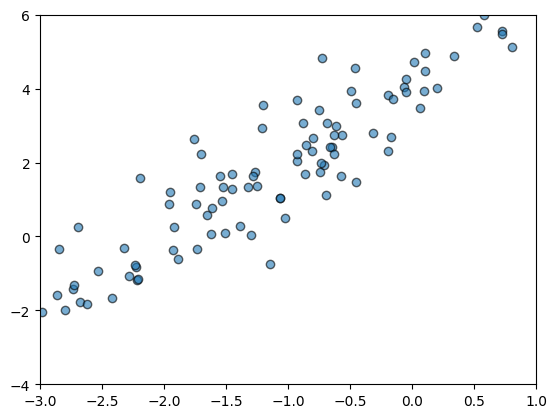

In [22]:
X = sample(100)
plot(X)

Plotting the data sampled from the previous problem should show something like this:

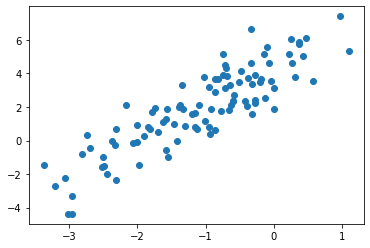

# Submitting to Gradescope
Before submitting to Gradescope, make sure that selecting "Runtime" -> "Restart and run all" completes all cells without errors.

1. Go to the File menu and choose "Download .ipynb". Make sure these files are named homework0.ipynb and homework0.py, respectively
2. Go to GradeScope through the canvas page and ensure your class is "BAN_CIS-5200-001 202530"
3. Select Homework 0
4. Upload the ipynb file with your written homework.
5. PLEASE CHECK THE TEST CASE OUTPUTS TO ENSURE YOUR SUBMISSION IS PROCESSED CORRECTLY!
You should be set! This assignment has test cases to give you feedback, but is not worth any points. However, completion of this assignment is required to pass the course.
